# Rolling test

#### Getting Data

In [1]:
import pandas as pd
from datetime import date
from datetime import timedelta
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt

weather_start_year = 2013
end_dt = '2020-02-29'
# #2 months:
# start_dt = '2019-02-01'

#6 months:
# start_dt = '2018-10-01'

# 12 months:
# start_dt = '2018-04-01'

# #24 months:
# start_dt = '2017-04-01'

# # #60 months:
# start_dt = '2014-04-01'

start_dt = '2013-12-01'

weekdays =['Pon', 'Wt', 'Sr', 'Czw', 'Pt', 'Sb', 'Nd']

def dzienTyg(dzienNum):
    if dzienNum == 0:
        return 'Pon'
    elif dzienNum == 1:
        return 'Wt'
    elif dzienNum == 2:
        return 'Sr'
    elif dzienNum == 3:
        return 'Czw'
    elif dzienNum == 4:
        return 'Pt'
    elif dzienNum == 5:
        return 'Sb'
    elif dzienNum == 6:
        return 'Nd'
    else:
        return 'Blad'
def date_fromisofromat(dt):
    y = int(dt[0: 4])
    m = int(dt[5: 7])
    d = int(dt[8:10])
    return date(y,m,d)

def combineData(start, end):
    startDt = date_fromisofromat(start)
    endDt   = date_fromisofromat(end)
    d = timedelta(days=1)
    m = relativedelta(months=+1)

    in_table = pd.read_csv(filepath_or_buffer= '../Data/20100301-20100331.csv', 
                       sep=';', 
                       engine='python')
    in_table= in_table.iloc[0:0] #drop all rows, leave columns

    while(startDt <= endDt):
        fileName = str(startDt).replace('-','') + '-' + str(startDt + m - d).replace('-','') + '.csv'
        in_table1 = pd.read_csv(filepath_or_buffer= '../Data/' +fileName, 
                           sep=';', 
                           engine='python')
        in_table = in_table.append(in_table1,ignore_index=True)
        startDt = startDt + relativedelta(months=+1)

    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].apply(lambda x: x.replace(',','.'))
    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].astype(float)
    in_table['Rok']     = in_table['Data'].apply(lambda x: x[0: 4]).astype(int)
    in_table['Miesiac'] = in_table['Data'].apply(lambda x: x[5: 7]).astype(int)
    in_table['Dzien']   = in_table['Data'].apply(lambda x: x[8:10]).astype(int)
    # in_table['Godz_mies']=(in_table['Dzien']-1)*24 +in_table['Godzina']
    return in_table
#     plt.show()
# Data, Godzina, Krajowe zapotrzebowanie na moc, Sumaryczna generacja JWCD, 
# Generacja PI, Generacja IRZ, Sumaryczna generacja nJWCD, 
# Krajowe saldo wymiany międzysystemowej równoległej, 
# Krajowe saldo wymiany międzysystemowej nierównoległej, 

dataAll = combineData(start_dt, end_dt)
dataAll = dataAll.loc[dataAll['Godzina'] != '2A']

dataAll['Godzina'] = dataAll['Godzina'].apply(
    lambda x: (int(str(x)))
)
dataAll['weekDayNum'] = dataAll['Data'].apply(
    lambda x: (date_fromisofromat(x).weekday())
)
dataAll['weekDay'] = dataAll['Data'].apply(
    lambda x: dzienTyg(date_fromisofromat(x).weekday())
)
dataAll['DataGodz'] = pd.to_datetime(dataAll['Data']) 

dataAll['DataGodz'] = dataAll['DataGodz'] + dataAll['Godzina'].apply(
    lambda x: relativedelta(hours=x)
)
    
modelData = dataAll[['Krajowe zapotrzebowanie na moc']]

#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz']] 
modelData2.set_index('DataGodz')
modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz','weekDay']]

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
def create_model(dane, sezon, maxiter = 20, regresor = None):
#     start = datetime.now()

    #auto ARIMA
    m = auto_arima(dane, 
           seasonal = True, 
           m=sezon, 
           maxiter = maxiter,
           trace = False,
           exogenous = regresor)#.summary()
#     print('autoARIMA time: ' + str(datetime.now() - start))
    order = m.get_params()['order']
    seasonal_order = m.get_params()['seasonal_order']
    print(order)
    print(seasonal_order)
    #SARIMAX
    fit_start =  datetime.now()
    model = SARIMAX(dane, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse', exog=regresor)
    model_fit = model.fit() 
    
#     print('fit time = ' + str(datetime.now() - fit_start))
    return model_fit

### Dane pogodowe

In [3]:
weather_cols = [
'Kod stacji'
,'Nazwa stacji'
,'Rok' 
,'Miesiąc' 
,'Dzień'
,'Godzina' 
,'Wysokość podstawy chmur CL CM szyfrowana [kod]'
,'Status pomiaru HPOD' 
,'Wysokość podstawy niższej  [m]'
,'Status pomiaru HPON' 
,'Wysokość podstawy wyższej [m]'
,'Status pomiaru HPOW' 
,'Wysokość podstawy tekstowy [opis]' 
,'Pomiar przyrzadem 1 (niższa) [P]'
,'Pomiar przyrzadem 2 (wyższa) [P]'
,'Widzialność  [kod]' 
,'Satus pomiaru WID' 
,'Widzialność operatora [m]' 
,'Status pomiaru WIDO' 
,'Widzialność automat [m]'
,'Status pomiaru WIDA' 
,'Zachmurzenie ogólne [oktanty]'
,'Status pomiaru NOG'  
,'Kierunek wiatru  [°]'
,'Status pomiaru KRWR' 
,'Prędkość wiatru  [m/s]' ######################################
,'Status pomiaru FWR'  
,'Poryw wiatru  [m/s]' 
,'Status pomiaru PORW' 
,'Temperatura powietrza [°C]' ######################################
,'Status pomiaru TEMP' 
,'Temperatura termometru zwilżonego [°C]'
,'Status pomiaru TTZW' 
,'Wskaźnik wentylacji [W/N]' 
,'Wskaźnik lodu [L/W]' 
,'Ciśnienie pary wodnej [hPa]'  
,'Status pomiaru CPW'  
,'Wilgotność względna [%]'
,'Status pomiaru WLGW' 
,'Temperatura punktu rosy [°C]' 
,'Status pomiaru TPTR' 
,'Ciśnienie na pozimie stacji [hPa]'  
,'Status pomiaru PPPS' 
,'Ciśnienie na pozimie morza [hPa]'
,'Status pomiaru PPPM' 
,'Charakterystyka tendencji [kod]' 
,'Wartość tendencji [wartość]'  
,'Status pomiaru APP'  
,'Opad za 6 godzin [mm]'  
,'Status pomiaru WO6G'
,'Rodzaj opadu za 6 godzin [kod]'
,'Status pomiaru ROPT'
,'Pogoda bieżąca [kod]'
,'Pogoda ubiegła [kod]'
,'Zachmurzenie niskie [oktanty]'
,'Status pomiaru CLCM'
,'Chmury CL [kod]'
,'Status pomiaru CHCL'
,'Chmury CL tekstem'
,'Chmury CM [kod]'
,'Status pomiaru CHCM'
,'Chmury CM tekstem'
,'Chmury CH [kod]'
,'Status pomiaru CHCH'
,'Chmury CH tekstem'
,'Stan gruntu [kod]'
,'Status pomiaru SGRN'
,'Niedosyt wilgotności [hPa}'
,'Status pomiaru DEFI'
,'Usłonecznienie'
,'Status pomiaru USLN'
,'Wystąpienie rosy [0/1]'
,'Status pomiaru ROSW'
,'Poryw maksymalny za okres WW [m/s]'
,'Status pomiaru PORK'
,'Godzina wystąpienia porywu'
,'Minuta wystąpienia porywu'
,'Temperatura gruntu -5 [°C]'
,'Status pomiaru TG05'
,'Temperatura gruntu -10 [°C]'
,'Status pomiaru TG10'
,'Temperatura gruntu -20 [°C]'
,'Status pomiaru TG20'
,'Temperatura gruntu -50 [°C]'
,'Status pomiaru TG50'
,'Temperatura gruntu -100 [°C]'
,'Status pomiaru TG100'
,'Temperatura minimalna za 12 godzin  [°C]'
,'Status pomiaru TMIN'
,'Temperatura maksymalna za 12 godzin [°C]'
,'Status pomiaru TMAX'
,'Temperatura minimalna przy gruncie za 12 godzin [°C]'
,'Status pomiaru TGMI'
,'Równoważnik wodny śniegu [mm/cm]'
,'Status pomiaru RWSN'
,'Wysokość pokrywy śnieżnej [cm]'
,'Status pomiaru PKSN'
,'Wysokość świeżo spadłego śniegu  [cm]'
,'Status pomiaru HSS'
,'Wysokość śniegu na poletku [cm]'
,'Status pomiaru GRSN'
,'Gatunek śniegu  [kod]'
,'Ukształtowanie pokrywy [kod]'
,'Wysokość próbki [cm]'
,'Status pomiaru HPRO'
,'Ciężar próbki [g]'
,'Status pomiaru CIPR'
]

In [4]:
def readWeatherFile(file_name):
    file = '../Additional Data/Weather/' + file_name
    df = pd.read_csv(filepath_or_buffer = file
                     ,engine='python'
                     ,sep = ','
                     ,header = None
                    )

    df.columns = weather_cols
    return df
# test:
# readWeatherFile('s_t_690_2017.csv')

In [5]:
# getting list of s_d_t .csv files

import glob
file_names_list = (glob.glob("..\\Additional Data\\Weather\\s_t_*.csv"))
lst=[]

for file_name in file_names_list:
    file_name = file_name[-16:]
    file_name = file_name.replace("\\","")
    lst.append(file_name)
#     print(file_name)
file_names_list = lst
lst=[]

In [6]:
names_to_drop=[]
for i in file_names_list:
    if(int(i[-8:-4]) < weather_start_year):
        names_to_drop.append(i)
for i in names_to_drop:
    file_names_list.remove(i)
file_names_list

['s_t_01_2020.csv',
 's_t_02_2020.csv',
 's_t_03_2020.csv',
 's_t_04_2020.csv',
 's_t_05_2020.csv',
 's_t_06_2020.csv',
 's_t_07_2020.csv',
 's_t_08_2020.csv',
 's_t_09_2020.csv',
 's_t_100_2013.csv',
 's_t_100_2014.csv',
 's_t_100_2015.csv',
 's_t_100_2016.csv',
 's_t_100_2017.csv',
 's_t_100_2018.csv',
 's_t_100_2019.csv',
 's_t_100_2020.csv',
 's_t_105_2013.csv',
 's_t_105_2014.csv',
 's_t_105_2015.csv',
 's_t_105_2016.csv',
 's_t_105_2017.csv',
 's_t_105_2018.csv',
 's_t_105_2019.csv',
 's_t_105_2020.csv',
 's_t_10_2020.csv',
 's_t_115_2013.csv',
 's_t_115_2014.csv',
 's_t_115_2015.csv',
 's_t_115_2016.csv',
 's_t_115_2017.csv',
 's_t_115_2018.csv',
 's_t_115_2019.csv',
 's_t_115_2020.csv',
 's_t_120_2013.csv',
 's_t_120_2014.csv',
 's_t_120_2015.csv',
 's_t_120_2016.csv',
 's_t_120_2017.csv',
 's_t_120_2018.csv',
 's_t_120_2019.csv',
 's_t_120_2020.csv',
 's_t_125_2013.csv',
 's_t_125_2014.csv',
 's_t_125_2015.csv',
 's_t_125_2016.csv',
 's_t_125_2017.csv',
 's_t_125_2018.csv',
 '

In [7]:
weatherDF = readWeatherFile(file_names_list[1]).iloc[0:0] #dummy
weatherDF = weatherDF[['Nazwa stacji'
            ,'Rok' 
            ,'Miesiąc' 
            ,'Dzień'
            ,'Godzina' 
            ,'Prędkość wiatru  [m/s]'
            ,'Temperatura powietrza [°C]']]
for file_name in file_names_list:
    weatherDF = weatherDF.append(
        readWeatherFile(file_name)[['Nazwa stacji'
            ,'Rok' 
            ,'Miesiąc' 
            ,'Dzień'
            ,'Godzina' 
            ,'Prędkość wiatru  [m/s]'
            ,'Temperatura powietrza [°C]']]
        ,ignore_index=True
        )
    print(file_name)
weatherDF.isna().sum()

s_t_01_2020.csv
s_t_02_2020.csv
s_t_03_2020.csv
s_t_04_2020.csv
s_t_05_2020.csv
s_t_06_2020.csv
s_t_07_2020.csv
s_t_08_2020.csv
s_t_09_2020.csv
s_t_100_2013.csv
s_t_100_2014.csv
s_t_100_2015.csv
s_t_100_2016.csv
s_t_100_2017.csv
s_t_100_2018.csv
s_t_100_2019.csv
s_t_100_2020.csv
s_t_105_2013.csv
s_t_105_2014.csv
s_t_105_2015.csv
s_t_105_2016.csv
s_t_105_2017.csv
s_t_105_2018.csv
s_t_105_2019.csv
s_t_105_2020.csv
s_t_10_2020.csv
s_t_115_2013.csv
s_t_115_2014.csv
s_t_115_2015.csv
s_t_115_2016.csv
s_t_115_2017.csv
s_t_115_2018.csv
s_t_115_2019.csv
s_t_115_2020.csv
s_t_120_2013.csv
s_t_120_2014.csv
s_t_120_2015.csv
s_t_120_2016.csv
s_t_120_2017.csv
s_t_120_2018.csv
s_t_120_2019.csv
s_t_120_2020.csv
s_t_125_2013.csv
s_t_125_2014.csv
s_t_125_2015.csv
s_t_125_2016.csv
s_t_125_2017.csv
s_t_125_2018.csv
s_t_125_2019.csv
s_t_125_2020.csv
s_t_135_2013.csv
s_t_135_2014.csv
s_t_135_2015.csv
s_t_135_2016.csv
s_t_135_2017.csv
s_t_135_2018.csv
s_t_135_2019.csv
s_t_135_2020.csv
s_t_155_2013.csv
s_t_155

Nazwa stacji                  0
Rok                           0
Miesiąc                       0
Dzień                         0
Godzina                       0
Prędkość wiatru  [m/s]        0
Temperatura powietrza [°C]    0
dtype: int64

In [8]:
#wywalenie odstających
weatherDF = weatherDF[~weatherDF['Nazwa stacji'].isin(
[
#     'WARSZAWA-OKĘCIE'
# ,'WROCŁAW-STRACHOWICE'
# ,'KRAKÓW-BALICE'
# ,'ŁÓDŹ-LUBLINEK'
# ,'GDAŃSK-ŚWIBNO'
# ,'POZNAŃ-ŁAWICA'
    'KASPROWY WIERCH',
    'ŚNIEŻKA',
    'ZAKOPANE'
])]

In [9]:
def date_from_row(x):
    y=x['Rok']
    m=x['Miesiąc']
    d=x['Dzień']
    return date(y,m,d)

In [10]:
weatherDF['DataGodz'] = weatherDF.apply(lambda x: date_from_row(x), axis = 1)
weatherDF['DataGodz'] = pd.to_datetime(weatherDF['DataGodz']) 

weatherDF['DataGodz'] = weatherDF['DataGodz'] + weatherDF['Godzina'].apply(
   lambda x: relativedelta(hours=x)
)

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [11]:
weatherAvg = weatherDF[
            ['Nazwa stacji',
           'Temperatura powietrza [°C]',
            'DataGodz']
         ].groupby('DataGodz',as_index=False).mean()

In [12]:
weatherAvg

,DataGodz,Temperatura powietrza [°C]
0,2013-01-01 00:00:00,2.221569
1,2013-01-01 01:00:00,2.098039
2,2013-01-01 02:00:00,1.962745
3,2013-01-01 03:00:00,1.956863
4,2013-01-01 04:00:00,1.817647
...,...,...
70123,2020-12-31 19:00:00,-0.229630
70124,2020-12-31 20:00:00,-0.379630
70125,2020-12-31 21:00:00,-0.511111
70126,2020-12-31 22:00:00,-0.666667


#### łączenie pogody z zapotrzebowaniem

In [13]:
dataAll = pd.merge(dataAll, weatherAvg, how='left',on='DataGodz')
dataAll['Godzina w tyg'] = dataAll.apply(lambda x: (24*x['weekDayNum']+x['Godzina'])%168, axis=1)
dataAll.head(25)

,Data,Godzina,Krajowe zapotrzebowanie na moc,Sumaryczna generacja JWCD,Generacja PI,Generacja IRZ,Sumaryczna generacja nJWCD,Krajowe saldo wymiany międzysystemowej równoległej,Krajowe saldo wymiany międzysystemowej nierównoległej,Rok,Miesiac,Dzien,weekDayNum,weekDay,DataGodz,Temperatura powietrza [°C],Godzina w tyg
0,2013-12-01,1,15386.225,"9832,163",-,-,"5966,800","-74,575","-325,588",2013,12,1,6,Nd,2013-12-01 01:00:00,2.878431,145
1,2013-12-01,2,14669.325,"9018,875",-,-,"6094,088","-112,600","-322,875",2013,12,1,6,Nd,2013-12-01 02:00:00,2.884314,146
2,2013-12-01,3,14326.238,"8523,213",-,-,"6233,700","-67,088","-331,788",2013,12,1,6,Nd,2013-12-01 03:00:00,2.909804,147
3,2013-12-01,4,14124.513,"8442,650",-,-,"6460,575","-83,650","-309,488",2013,12,1,6,Nd,2013-12-01 04:00:00,2.998039,148
4,2013-12-01,5,14132.888,"8448,988",-,-,"6675,938","-17,775","-292,100",2013,12,1,6,Nd,2013-12-01 05:00:00,3.086275,149
5,2013-12-01,6,14252.825,"8538,363",-,-,"6914,925","-77,813","-262,888",2013,12,1,6,Nd,2013-12-01 06:00:00,3.237037,150
6,2013-12-01,7,14539.450,"8610,450",-,-,"7065,113","-84,163","-214,838",2013,12,1,6,Nd,2013-12-01 07:00:00,3.366038,151
7,2013-12-01,8,14760.538,"8495,188",-,-,"7437,538","-261,438","-108,038",2013,12,1,6,Nd,2013-12-01 08:00:00,3.673585,152
8,2013-12-01,9,15524.100,"8693,875",-,-,"7641,025","-255,088","-30,238",2013,12,1,6,Nd,2013-12-01 09:00:00,4.084906,153
9,2013-12-01,10,16581.800,"9232,338",-,-,"7740,725","-345,800","-12,450",2013,12,1,6,Nd,2013-12-01 10:00:00,4.558491,154


### Święta z kalendarza

In [14]:
import holidays
pl_holidays = holidays.Poland()
dataAll['Swieto'] = dataAll['DataGodz'].apply(lambda x: int(x in pl_holidays))

In [15]:
dataAll.loc[
    (dataAll['Miesiac']==12) & (dataAll['Dzien'].isin([24,25,26,27,28,29,30,31]))
    , 'Swieto'] = 1

In [16]:
dataAll[(dataAll['Miesiac']==12) & (dataAll['Dzien'].isin([24,25,26,27,28,29,30,31]))]

,Data,Godzina,Krajowe zapotrzebowanie na moc,Sumaryczna generacja JWCD,Generacja PI,Generacja IRZ,Sumaryczna generacja nJWCD,Krajowe saldo wymiany międzysystemowej równoległej,Krajowe saldo wymiany międzysystemowej nierównoległej,Rok,Miesiac,Dzien,weekDayNum,weekDay,DataGodz,Temperatura powietrza [°C],Godzina w tyg,Swieto
552,2013-12-24,1,15694.200,"8090,463",-,-,"7592,313","1,063","21,663",2013,12,24,1,Wt,2013-12-24 01:00:00,3.105882,25,1
553,2013-12-24,2,14618.675,"7425,613",-,-,"7642,938","-279,663","-14,950",2013,12,24,1,Wt,2013-12-24 02:00:00,3.284314,26,1
554,2013-12-24,3,14078.788,"7237,388",-,-,"7711,425","-228,625","-31,888",2013,12,24,1,Wt,2013-12-24 03:00:00,3.503922,27,1
555,2013-12-24,4,13787.425,"7394,450",-,-,"7666,813","-129,913","-29,900",2013,12,24,1,Wt,2013-12-24 04:00:00,3.623529,28,1
556,2013-12-24,5,13863.813,"7308,450",-,-,"7736,775","-205,238","-22,388",2013,12,24,1,Wt,2013-12-24 05:00:00,3.827451,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53313,2019-12-31,20,18114.775,"8515,750","177,425","75,800","9664,763","-1387,025","1323,475",2019,12,31,1,Wt,2019-12-31 20:00:00,4.170370,44,1
53314,2019-12-31,21,16998.238,"8468,513","160,225","78,650","9400,925","-1835,613","978,088",2019,12,31,1,Wt,2019-12-31 21:00:00,3.894444,45,1
53315,2019-12-31,22,16239.375,"8200,550","97,225","75,450","9186,300","-1881,188","752,150",2019,12,31,1,Wt,2019-12-31 22:00:00,3.564815,46,1
53316,2019-12-31,23,15784.000,"8009,388","-13,650","75,113","8796,375","-1719,838","718,250",2019,12,31,1,Wt,2019-12-31 23:00:00,3.201852,47,1


## Pętla godzinowa

In [17]:
models_num = 168

def petlaGodzinowa(dataAll):
    my_models = [None] * models_num
    for i in range(models_num):
        print('##### startuje dopasowanie modelu dla godziny: ' + str(i))
        my_models[i] = create_model(
            dataAll[dataAll['Godzina w tyg'] ==i]['Krajowe zapotrzebowanie na moc']
            ,4
            ,regresor = dataAll[dataAll['Godzina w tyg'] ==i][['Temperatura powietrza [°C]','Swieto']]
        )
        print('##### Koniec dopasowania modelu dla godziny: ' + str(i))
        print('#####')
    return my_models

In [18]:
import winsound
frequency = 3500  # Set Frequency To 2500 Hertz
duration = 3000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

## Prognozowanie

In [19]:
test_start = '2019-04-01'
test_end = '2020-02-29'
weatherAvg['Swieto'] = weatherAvg['DataGodz'].apply(lambda x: int(x in pl_holidays))


In [20]:
pd.to_datetime('2019-01-01')

Timestamp('2019-01-01 00:00:00')

In [21]:
weatherAvg.loc[
    (weatherAvg['DataGodz'] >= pd.to_datetime('2019-12-24'))&
    (weatherAvg['DataGodz'] < pd.to_datetime('2020-01-01'))
    , 'Swieto'] = 1

In [22]:
weatherAvg.loc[
    (weatherAvg['DataGodz'] >= pd.to_datetime('2019-05-02'))&
    (weatherAvg['DataGodz'] < pd.to_datetime('2019-05-03'))
    , 'Swieto'] = 1

In [23]:
weatherAvg.loc[
    (weatherAvg['DataGodz'] >= pd.to_datetime('2019-05-02'))&
    (weatherAvg['DataGodz'] < pd.to_datetime('2019-05-05'))
    ]

,DataGodz,Temperatura powietrza [°C],Swieto
55488,2019-05-02 00:00:00,9.427778,1
55489,2019-05-02 01:00:00,9.164151,1
55490,2019-05-02 02:00:00,8.722222,1
55491,2019-05-02 03:00:00,8.512963,1
55492,2019-05-02 04:00:00,8.511111,1
...,...,...,...
55555,2019-05-04 19:00:00,6.801852,0
55556,2019-05-04 20:00:00,5.942593,0
55557,2019-05-04 21:00:00,5.279630,0
55558,2019-05-04 22:00:00,4.742593,0


In [24]:
def pronozowanie(weatherAvg, test_start, test_end, my_models, bad_model_id_list=None):
    startWeekDayNum = pd.to_datetime(test_start).weekday()
#     print('week day num:', startWeekDayNum, startWeekDayNum*24)
    weatherTest = weatherAvg[weatherAvg['DataGodz'].between(test_start, test_end)][['Temperatura powietrza [°C]','Swieto']]
    forecast_steps = int(np.shape(weatherTest)[0] / 168) #int(2208/24)
#     print(len(my_models))
    forecasted_data=[None]*models_num
    k=0
    for i in range(startWeekDayNum*24, models_num):
        
        forecasted_data[k] = my_models[i].forecast(forecast_steps,
                                                  exog = weatherTest[k:forecast_steps*models_num:models_num])
        if np.std(forecasted_data[k]) > 1000: print(k,np.std(forecasted_data[k])) 
        k=k+1

    for i in range(startWeekDayNum*24):
#         print(2,i)
        forecasted_data[k] = my_models[i].forecast(forecast_steps,
                                                  exog = weatherTest[k:forecast_steps*models_num:models_num])
        if np.std(forecasted_data[k]) > 1000: print(k,np.std(forecasted_data[k])) 
        k=k+1
    #poprawka na blednie wytrenowany model
    
    if bad_model_id_list != None:
        bad_len = len(bad_model_id_list)
        for bad_model_id in bad_model_id_list:
            print(forecasted_data[bad_model_id])
            for i in range(len(forecasted_data[bad_model_id])):
                forecasted_data[bad_model_id] = (forecasted_data[bad_model_id-bad_len] 
                                                 + forecasted_data[bad_model_id+bad_len])/2
            print(forecasted_data[bad_model_id])
    
    combined_forecasted_data = [None] * forecast_steps * models_num
    for j in range(forecast_steps):
        for i in range(1,models_num):
            combined_forecasted_data[j * models_num + i-1] = forecasted_data[i].iloc[j]
        combined_forecasted_data[j * models_num + models_num-1] = forecasted_data[0].iloc[j]
    combined_forecasted_data = pd.Series(combined_forecasted_data)
    return combined_forecasted_data

## Obliczanie błędu

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
# import datetime
def obliczanieBledu(combined_forecasted_data, test_start, test_end, sample, title, sample_begin = 0):
    test_start_full = test_start
    test_start = str(test_start)[:7]+'-01'
    
    test_data_full = combineData(str(test_start)[:10], str(test_end)[:10])
    test_data= test_data_full['Krajowe zapotrzebowanie na moc']
    test_data_full['DataGodz'] = pd.to_datetime(test_data_full['Data'])
    test_data = test_data[test_data_full['DataGodz'] >= test_start_full].reset_index(drop=True)
    print(test_data)
    # sample = 720#2160   
    mape = mean_absolute_percentage_error(test_data.iloc[sample_begin:sample], combined_forecasted_data.iloc[sample_begin:sample])
    plt.figure(figsize=[12,4])
    test_data.iloc[sample_begin:sample].plot()
    combined_forecasted_data.iloc[sample_begin:sample].plot()
    plt.legend(['Dane testowe', 'Prognoza'])
    plt.grid()
    plt.xlabel('Krok czasowy (godzina)')
    plt.ylabel('Zapotrzebowanie na moc [MW]')
    plt.ylim(12000,26000)
    # plt.xlim(0, 12.1)
    # plt.hlines(0,-1,13,'black')
    plt.title('Prognoza zapotrzebowania na moc: '+title[:-4]+' '+title[-4:])
    #plt.savefig('Prognoza zapotrzebowania na moc '+title)
    
    return mape

# Main

In [27]:
def d(data):
    return pd.to_datetime(data)


In [88]:
my_list = [
#      {'title': 'styczen2019',     'start_t': d('2014-01-01'), 'end_t': d('2019-01-01'), 'start_p': d('2019-01-01'), 'end_p': d('2019-02-01'), 'sample': 744, 'mape': None}
#      ,{'title': 'luty2019',       'start_t': d('2014-02-01'), 'end_t': d('2019-02-01'), 'start_p': d('2019-02-01'), 'end_p': d('2019-03-01'), 'sample': 672, 'mape': None}
#      ,{'title': 'marzec2019',     'start_t': d('2014-03-01'), 'end_t': d('2019-03-01'), 'start_p': d('2019-03-01'), 'end_p': d('2019-04-01'), 'sample': 744, 'mape': None}
#      {'title': 'kwiecien2019',    'start_t': d('2014-04-01'), 'end_t': d('2019-04-01'), 'start_p': d('2019-04-01'), 'end_p': d('2019-05-31'), 'sample': 24,  'bad_model_id_list': None, 'mape': None}#'sample': 720, 'mape': None}
#     {'title': 'maj2019',         'start_t': d('2014-05-01'), 'end_t': d('2019-05-01'), 'start_p': d('2019-05-01'), 'end_p': d('2019-07-01'), 'sample': 24, 'bad_model_id_list': None, 'mape': None}#744, 'mape': None}
#     {'title': 'czerwiec2019',    'start_t': d('2014-06-01'), 'end_t': d('2019-06-01'), 'start_p': d('2019-06-01'), 'end_p': d('2019-08-01'), 'sample': 24, 'bad_model_id_list': None, 'mape': None}#720, 'mape': None}
#     {'title': 'lipiec2019',      'start_t': d('2014-07-01'), 'end_t': d('2019-07-01'), 'start_p': d('2019-07-01'), 'end_p': d('2019-09-01'), 'sample': 24, 'bad_model_id_list': None, 'mape': None}#744, 'mape': None}
#     {'title': 'sierpien2019',    'start_t': d('2014-08-01'), 'end_t': d('2019-08-01'), 'start_p': d('2019-08-01'), 'end_p': d('2019-10-01'), 'sample': 24, 'bad_model_id_list': None, 'mape': None}#744, 'mape': None}
#     {'title': 'wrzesien2019',    'start_t': d('2014-09-01'), 'end_t': d('2019-09-01'), 'start_p': d('2019-09-01'), 'end_p': d('2019-11-01'), 'sample': 24, 'bad_model_id_list': [18,19,20], 'mape': None}#720, 'mape': None}
#     {'title': 'pazdziernik2019', 'start_t': d('2014-10-01'), 'end_t': d('2019-10-01'), 'start_p': d('2019-10-01'), 'end_p': d('2019-12-01'), 'sample': 24, 'bad_model_id_list': None, 'mape': None}#744, 'mape': None}
#     {'title': 'listopad2019',    'start_t': d('2014-11-01'), 'end_t': d('2019-11-01'), 'start_p': d('2019-11-01'), 'end_p': d('2020-01-01'), 'sample': 24, 'bad_model_id_list': None, 'mape': None}#720, 'mape': None}
#     {'title': 'grudzien2019',    'start_t': d('2014-12-01'), 'end_t': d('2019-12-01'), 'start_p': d('2019-12-01'), 'end_p': d('2020-02-01'), 'sample': 24, 'bad_model_id_list': [17,18], 'mape': None}#744, 'mape': None}
#     {'title': 'styczen2020',     'start_t': d('2015-01-01'), 'end_t': d('2020-01-01'), 'start_p': d('2020-01-01'), 'end_p': d('2020-03-01'), 'sample': 24, 'bad_model_id_list': None, 'mape': None}#744, 'mape': None}
#     {'title': 'luty2020',        'start_t': d('2015-02-01'), 'end_t': d('2020-02-01'), 'start_p': d('2020-02-01'), 'end_p': d('2020-04-01'), 'sample': 24, 'bad_model_id_list': None, 'mape': None}#696, 'mape': None}
    {'title': 'marzec2020',      'start_t': d('2015-03-01'), 'end_t': d('2020-03-01'), 'start_p': d('2020-03-01'), 'end_p': d('2020-05-01'), 'sample': 24, 'bad_model_id_list': None, 'mape': None}#744, 'mape': None} #'sample': 744,
#     {'title': 'marzec_kwiecien2020', 'start_t': d('2015-03-01'), 'end_t': d('2020-03-01'), 'start_p': d('2020-03-01'), 'end_p': d('2020-06-01'), 'sample': 1464, 'mape': None}
#     {'title': 'marzec_kwiecien_maj2020', 'start_t': d('2015-03-01'), 'end_t': d('2020-03-01'), 'start_p': d('2020-03-01'), 'end_p': d('2020-07-01'), 'sample': 2208, 'mape': None}
#     {'title': 'poprawiony grudzien2019',    'start_t': d('2014-12-01'), 'end_t': d('2019-12-01'), 'start_p': d('2019-12-01'), 'end_p': d('2020-02-01'), 'sample': 744, 'mape': None}
#     {'title': 'poprawiony styczen2020',     'start_t': d('2015-01-01'), 'end_t': d('2020-01-01'), 'start_p': d('2020-01-01'), 'end_p': d('2020-03-01'), 'sample': 744, 'mape': None}

## TESTS:    
#     ,{'title': '_TEST_lipiec2019week2',      'start_t': d('2014-07-08'), 'end_t': d('2019-07-08'), 'start_p': d('2019-07-08'), 'end_p': d('2019-09-08'), 'sample': 744, 'mape': None}
#     ,{'title': '_TEST_lipiec2019week3',      'start_t': d('2014-07-15'), 'end_t': d('2019-07-15'), 'start_p': d('2019-07-15'), 'end_p': d('2019-09-15'), 'sample': 744, 'mape': None}
#     ,{'title': '_TEST_lipiec2019week4',      'start_t': d('2014-07-22'), 'end_t': d('2019-07-22'), 'start_p': d('2019-07-22'), 'end_p': d('2019-09-22'), 'sample': 744, 'mape': None}
]
prognoza = []
modele=[]

In [31]:
my_list[0]['title'][-4:]

'2019'

In [32]:
from pathlib import Path
for miesiac in my_list:
    Path(miesiac['title']).mkdir(parents=True, exist_ok=True)

In [33]:
train_new_models = False #False True

30 1212.1305949887835
31 2102.648851090648
32 2713.2865094522563
33 2791.214008832002
34 2606.47310567375
35 2425.3461721007916
36 2399.0114855186794
37 2369.348992668726
38 2340.085987380627
39 2279.3822595069964
40 2303.374988352608
41 2232.3651661056015
42 2141.844892214536
43 2031.2372489572783
44 1964.6443429349447
45 1838.04897310341
46 1559.378282546318
47 1255.2945032062598
0       15696.788
1       15122.850
2       14699.050
3       14671.550
4       14606.488
          ...    
2202    14902.925
2203    15072.800
2204    15508.413
2205    15265.900
2206    14296.763
Name: Krajowe zapotrzebowanie na moc, Length: 2207, dtype: float64


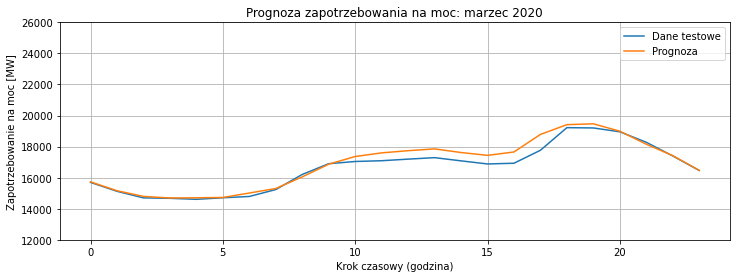

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
import warnings
warnings.filterwarnings('ignore')

for miesiac in my_list:
    if(train_new_models == True):
        model = petlaGodzinowa(
            dataAll[
                (dataAll['DataGodz'] >= miesiac['start_t']) & 
                (dataAll['DataGodz'] < miesiac['end_t'])
            ]
        )
        for i in range(len(model)):
            model[i].save(miesiac['title']+'/'+miesiac['title']+'_'+str(i)+'.model')
            log_text = str(i) + ' order: '+str(model[i].model.order) + str(model[i].model.seasonal_order) +'\n'
            with open(miesiac['title']+'_model_list.txt', "a") as file_object:
                file_object.write(log_text)
    else:
        model =[]
        for i in range(168):
#             print(i)
            model.append(SARIMAXResults.load(miesiac['title']+'/'+miesiac['title']+'_'+str(i)+'.model'))
#         print(model)
#     modele.append(model)
    prog = pronozowanie(weatherAvg, miesiac['start_p'], miesiac['end_p'], model, bad_model_id_list = miesiac['bad_model_id_list'])
    prognoza.append(prog)
    miesiac['mape'] = obliczanieBledu(prog, miesiac['start_p'], miesiac['end_p'], miesiac['sample'], miesiac['title'], sample_begin=0)

In [35]:
prog[168*3:24+168*3]

504    16243.428028
505    15679.767327
506    15323.679458
507    15241.391810
508    15272.595083
509    15263.379256
510    15559.252190
511    15827.721511
512    16527.902991
513    17343.992834
514    17814.894495
515    17984.679269
516    18120.638462
517    18266.479583
518    18009.837365
519    17765.058087
520    17988.450122
521    19158.519826
522    19871.118323
523    19984.914412
524    19491.138021
525    18678.376687
526    17837.230002
527    16859.346329
dtype: float64

In [90]:
my_list

[{'title': 'marzec2020',
  'start_t': Timestamp('2015-03-01 00:00:00'),
  'end_t': Timestamp('2020-03-01 00:00:00'),
  'start_p': Timestamp('2020-03-01 00:00:00'),
  'end_p': Timestamp('2020-05-01 00:00:00'),
  'sample': 24,
  'bad_model_id_list': None,
  'mape': 1.510983209857715}]

In [ ]:
my_list

In [ ]:
my_list

In [ ]:
plt.figure(figsize=[12,4])
prog[:720].plot()

In [ ]:
dataAll[
            (dataAll['DataGodz'] >= my_list[0]['start_p']) & 
            (dataAll['DataGodz'] < my_list[0]['end_p'])
        ]

In [37]:
import winsound
frequency = 1500  # Set Frequency To 2500 Hertz
duration = 3000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [ ]:
for miesiac in my_list:
    with open('MAPE list.txt', "a") as file_object:
        text = miesiac['title'] + ' MAPE: ' +str(miesiac['mape']) +'\n'
        file_object.write(text)